In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
from land_use_rules_test import land_use_transformation, LAND_UNDEVELOPED, LAND_LOWPRICE, LAND_HIGHPRICE, LAND_FIXED, LAND_ROAD
from land_demand_utils import load_land_demand, has_demand
from suitability_utils import load_suitability
from random_walk import create_random_walk_demand_map

# Constants
size = (640, 873)
steps = 20
num_experiments = 10
output_path = "D:/wildfire/Output_10"

# Load data
suitability_map = pd.read_csv("D:/wildfire/Suitablity.csv", header=None).values
initial_map = pd.read_csv("D:/wildfire/Initial_final.csv", header=None).values
initial_population_map = pd.read_csv("D:/wildfire/Population_2000.csv", header=None).values
initial_map[initial_map == 5] = 4

matrix1 = pd.read_csv('D:/wildfire/R_highway.csv', header=None).to_numpy()
matrix2 = pd.read_csv('D:/wildfire/R_coastline.csv', header=None).to_numpy()
accessibility_map = (1 + matrix1) * (1 + 0.2 * matrix2)

# Color map for land types
colors = {
    LAND_UNDEVELOPED: "#BDFFE2",
    LAND_LOWPRICE: "#FFFF71",
    LAND_HIGHPRICE: "#FB8B75",
    LAND_FIXED: "#BED2FF",
    LAND_ROAD: "#B6ABBA"
}
cmap = ListedColormap([colors[x] for x in [LAND_UNDEVELOPED, LAND_LOWPRICE, LAND_HIGHPRICE, LAND_FIXED, LAND_ROAD]])

# Function to simulate land use transformation
def simulate_land_use(map, population_map, steps, size=(640, 873)):
    for step in range(steps):
        growth_rate_map = create_random_walk_demand_map(size, mean=2.68, std=1.86)  # Random walk growth rate
        demand_map = population_map * (1 +growth_rate_map)  # Demand map as product of population and growth rate
        
        new_map = land_use_transformation(map, suitability_map, accessibility_map, demand_map)
        new_map[map == LAND_ROAD] = LAND_ROAD 

        if step == 24:
            x_start = size[0] // 2 - 10
            y_start = size[1] // 2 - 10
            for i in range(x_start, x_start + 20):
                for j in range(y_start, y_start + 20):
                    if new_map[i, j] not in (LAND_FIXED, LAND_ROAD):
                        new_map[i, j] = LAND_UNDEVELOPED

        population_map = demand_map  # Update the population map for the next iteration
        map = new_map
        
    return map

np.random.seed(2)

# Initialize growth count map
growth_count_map = np.zeros(size)

# Perform simulations
for experiment_index in range(num_experiments):
    final_map = simulate_land_use(initial_map.copy(), initial_population_map.copy(), steps)
    
    # Calculate changes only from 0 to 1 or 0 to 2
    growth_map = (initial_map == LAND_UNDEVELOPED) & ((final_map == LAND_LOWPRICE) | (final_map == LAND_HIGHPRICE))
    growth_count_map += growth_map
    
    # Save each experiment result
    experiment_filename = f"{output_path}/experiment_{experiment_index + 1}.csv"
    pd.DataFrame(final_map).to_csv(experiment_filename, header=False, index=False)

# Save the growth count map as a CSV file
growth_count_filename = f"{output_path}/growth_count_map.csv"
pd.DataFrame(growth_count_map).to_csv(growth_count_filename, header=False, index=False)

# Calculate thresholds using percentiles for visualization
lower_threshold = np.percentile(growth_count_map[growth_count_map > 0], 33)
upper_threshold = np.percentile(growth_count_map[growth_count_map > 0], 66)

# Determine growth areas by dividing based on the lower and upper thresholds
growth_lower = (growth_count_map > 0) & (growth_count_map <= lower_threshold)
growth_middle = (growth_count_map > lower_threshold) & (growth_count_map <= upper_threshold)
growth_upper = growth_count_map > upper_threshold

# Create result visualization
result_image = np.where(growth_upper, 2, np.where(growth_middle, 1, np.where(growth_lower, 0, np.nan)))

# Save the result as an image
plt.figure(figsize=(15, 10))
plt.imshow(result_image, cmap=ListedColormap(["#FB8B75", "#FFFF71", "#BDFFE2"]))  # Adjust colors if needed
plt.title('Growth Areas (Green: Upper Third, Purple: Middle Third, Yellow: Lower Third)')
plt.colorbar()
output_image_path = f"{output_path}/final_map.png"
plt.savefig(output_image_path)
plt.close()

print(f"Simulation completed and image saved as {output_image_path}")
print(f"Growth count map saved as {growth_count_filename}")

Simulation completed and image saved as D:/wildfire/Output_10/final_map.png
Growth count map saved as D:/wildfire/Output_10/growth_count_map.csv


AUC: 0.8428
Balanced Accuracy: 0.5500
Mean %Dev Correct: 53.5125
1023
ID: 54.25%
IU: 98.35%
ID cell number: 1023
IU cell number: 545726
N - ID - IU: 11971


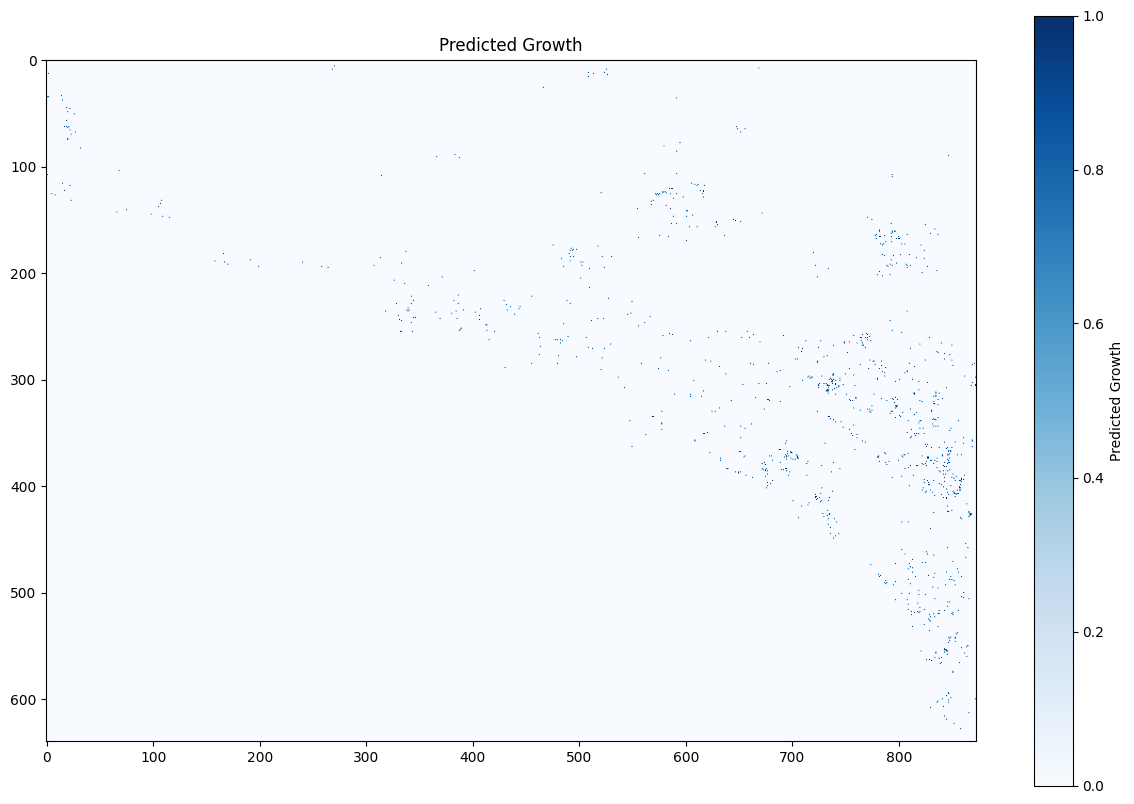

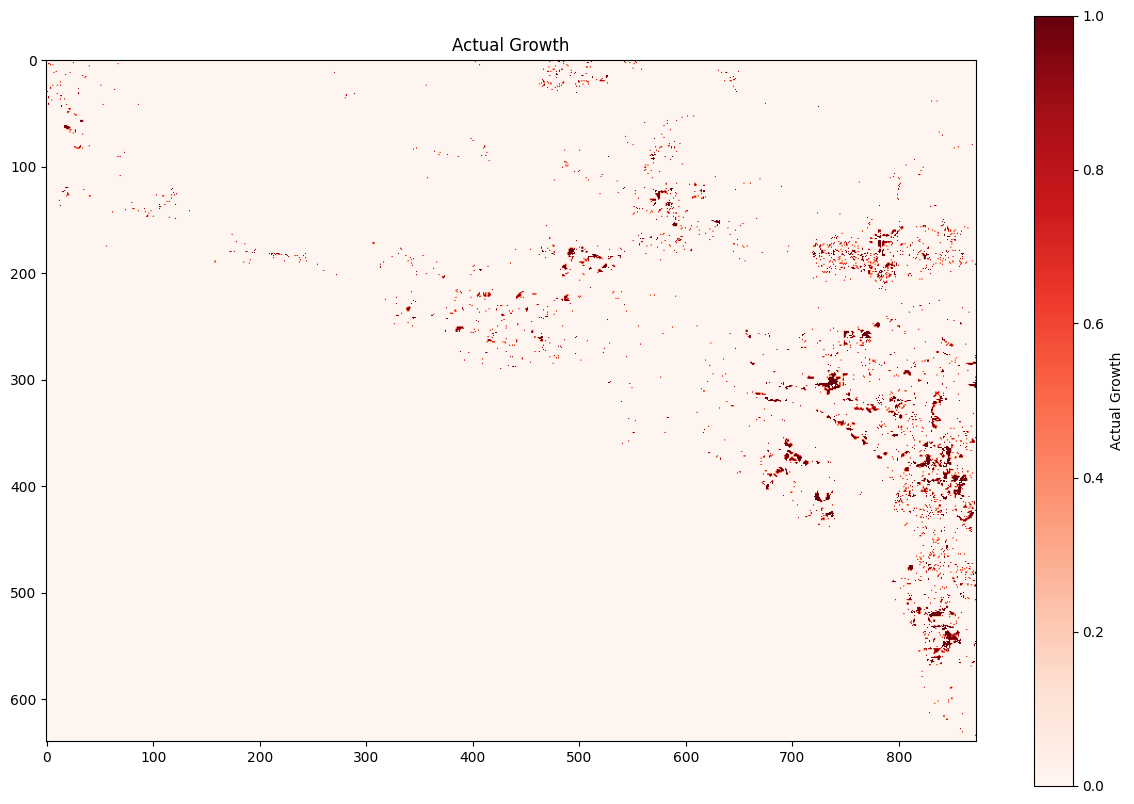

Predicted growth cells matrix saved to /home/limingl/wildfire/CA_model/Output_811/ID_matrix.csv


In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
import matplotlib.pyplot as plt


predicted_csv = "/home/limingl/wildfire/CA_model/Output_811/Growth_Matrix.csv"

#actual_csv = "/home/limingl/wildfire/CA_model/Growth_2021.csv"  # 替换成你的实际增长CSV文件路径

actual_csv = "/home/limingl/wildfire/CA_model/Output_10/Acutal_Growth_Matrix.csv" 
predicted_growth = pd.read_csv(predicted_csv, header=None).to_numpy()
actual_growth = pd.read_csv(actual_csv, header=None).to_numpy()

# 将矩阵转换为一维数组
predicted_growth_flat = predicted_growth.flatten()
actual_growth_flat = actual_growth.flatten()

# 设置阈值
threshold = 10

# 计算 ROC AUC
auc = roc_auc_score(actual_growth_flat, predicted_growth_flat)
print(f"AUC: {auc:.4f}")

# 计算 Balanced Accuracy
# 将预测值二值化
predicted_growth_binary = (predicted_growth_flat >= threshold).astype(int)
balanced_acc = balanced_accuracy_score(actual_growth_flat, predicted_growth_binary)
print(f"Balanced Accuracy: {balanced_acc:.4f}")

# 计算 Mean %Dev Correct
# 计算一个cell变为1的平均概率
mean_predicted_probs = predicted_growth_flat / 10

# 因为实际增长值只有0或1，计算百分比误差：
mask = actual_growth_flat == 1
#mask = mean_predicted_probs >= 1
percent_dev = np.abs((actual_growth_flat[mask] - mean_predicted_probs[mask])) * 100
mean_dev_correct = np.mean(percent_dev)
print(f"Mean %Dev Correct: {mean_dev_correct:.4f}")

# 计算真实增长的cell占预测增长的cell的百分比
predicted_growth_cells = (predicted_growth_flat >= threshold).astype(int)

true_positives = np.sum((actual_growth_flat == 1) & (predicted_growth_cells == 1))
#act_grow = np.sum(actual_growth_flat == 1)
#print(act_grow)
act_grow = np.sum(predicted_growth_cells == 1)
print(act_grow)
percentage = (true_positives / act_grow) * 100

print(f"ID: {percentage:.2f}%")


predicted_non_growth_cells = (predicted_growth_flat <= 10 - threshold).astype(int)

true_negetives = np.sum((actual_growth_flat == 0) & (predicted_non_growth_cells == 1))
act_non_grow = np.sum(actual_growth_flat == 0)
percentage = (true_negetives / act_non_grow) * 100

print(f"IU: {percentage:.2f}%")

print(f"ID cell number: {np.sum(predicted_growth_cells)}")
print(f"IU cell number: {np.sum(predicted_non_growth_cells)}")
print(f"N - ID - IU: {640 * 873 - np.sum(predicted_growth_cells) - np.sum(predicted_non_growth_cells)}")


plt.figure(figsize=(15, 10))
predicted_growth_visual = (predicted_growth >= threshold).astype(int)
plt.imshow(predicted_growth_visual, cmap='Blues')
plt.title('Predicted Growth')
cbar_pred = plt.colorbar()
cbar_pred.set_label('Predicted Growth')
plt.show()

# 可视化实际增长
plt.figure(figsize=(15, 10))
plt.imshow(actual_growth, cmap='Reds')
plt.title('Actual Growth')
cbar_act = plt.colorbar()
cbar_act.set_label('Actual Growth')
plt.show()

predicted_growth_cells_matrix = predicted_growth_cells.reshape(predicted_growth.shape)

# 保存为 CSV 文件
output_csv_path = "/home/limingl/wildfire/CA_model/Output_811/ID_matrix.csv"  # 替换成你要保存的路径
pd.DataFrame(predicted_growth_cells_matrix).to_csv(output_csv_path, header=False, index=False)

print(f"Predicted growth cells matrix saved to {output_csv_path}")



In [8]:
import numpy as np
import pandas as pd

# 加载CSV文件
predicted_csv = "/home/limingl/wildfire/CA_model/Output_811/Experiment_1.csv"  # 替换成你的预测矩阵CSV文件路径
initial_csv = "/home/limingl/wildfire/CA_model/Initial_final.csv"  # 替换成你的初始矩阵CSV文件路径
id_csv = "/home/limingl/wildfire/CA_model/Output_811/ID_matrix.csv"  # 替换成你的ID矩阵CSV文件路径
actual_growth_csv = "/home/limingl/wildfire/CA_model/Output_10/Acutal_Growth_Matrix.csv"  # 替换成你的实际增长矩阵CSV文件路径

#actual_growth_csv = "/home/limingl/wildfire/CA_model/Growth_2021.csv" 

predicted_matrix = pd.read_csv(predicted_csv, header=None).to_numpy()
initial_matrix = pd.read_csv(initial_csv, header=None).to_numpy()
id_matrix = pd.read_csv(id_csv, header=None).to_numpy()
actual_growth_matrix = pd.read_csv(actual_growth_csv, header=None).to_numpy()

# 生成预测增长矩阵
predicted_growth_matrix = (initial_matrix == 0) & ((predicted_matrix == 1) | (predicted_matrix == 2))
predicted_growth_matrix = predicted_growth_matrix.astype(int)

# 计算M
M = np.sum(predicted_growth_matrix)
print(f"M: {M}")

# 生成新矩阵并计算VC
vc_matrix = (predicted_growth_matrix == 1) & (id_matrix == 0) & (actual_growth_matrix == 1)
vc_matrix = vc_matrix.astype(int)
VC = np.sum(vc_matrix)
print(f"VC: {VC}")

# 生成新矩阵并计算IC
ic_matrix = (predicted_growth_matrix == 1) & (id_matrix == 1) & (actual_growth_matrix == 1)
ic_matrix = ic_matrix.astype(int)
IC = np.sum(ic_matrix)

result = (VC*11971)/((M - 1023)*(M - IC))
print(f"IC: {IC}")
print(result)
# # 可选的：保存生成的新矩阵到CSV文件
# # 保存预测增长矩阵
# predicted_growth_path = "path/to/save/predicted_growth_matrix.csv"
# pd.DataFrame(predicted_growth_matrix).to_csv(predicted_growth_path, header=False, index=False)



M: 6572
VC: 1999
IC: 555
0.716718291985407


AUC: 0.8727
Balanced Accuracy: 0.8708
Mean %Dev Correct: 3.0674
ID: 22.79%


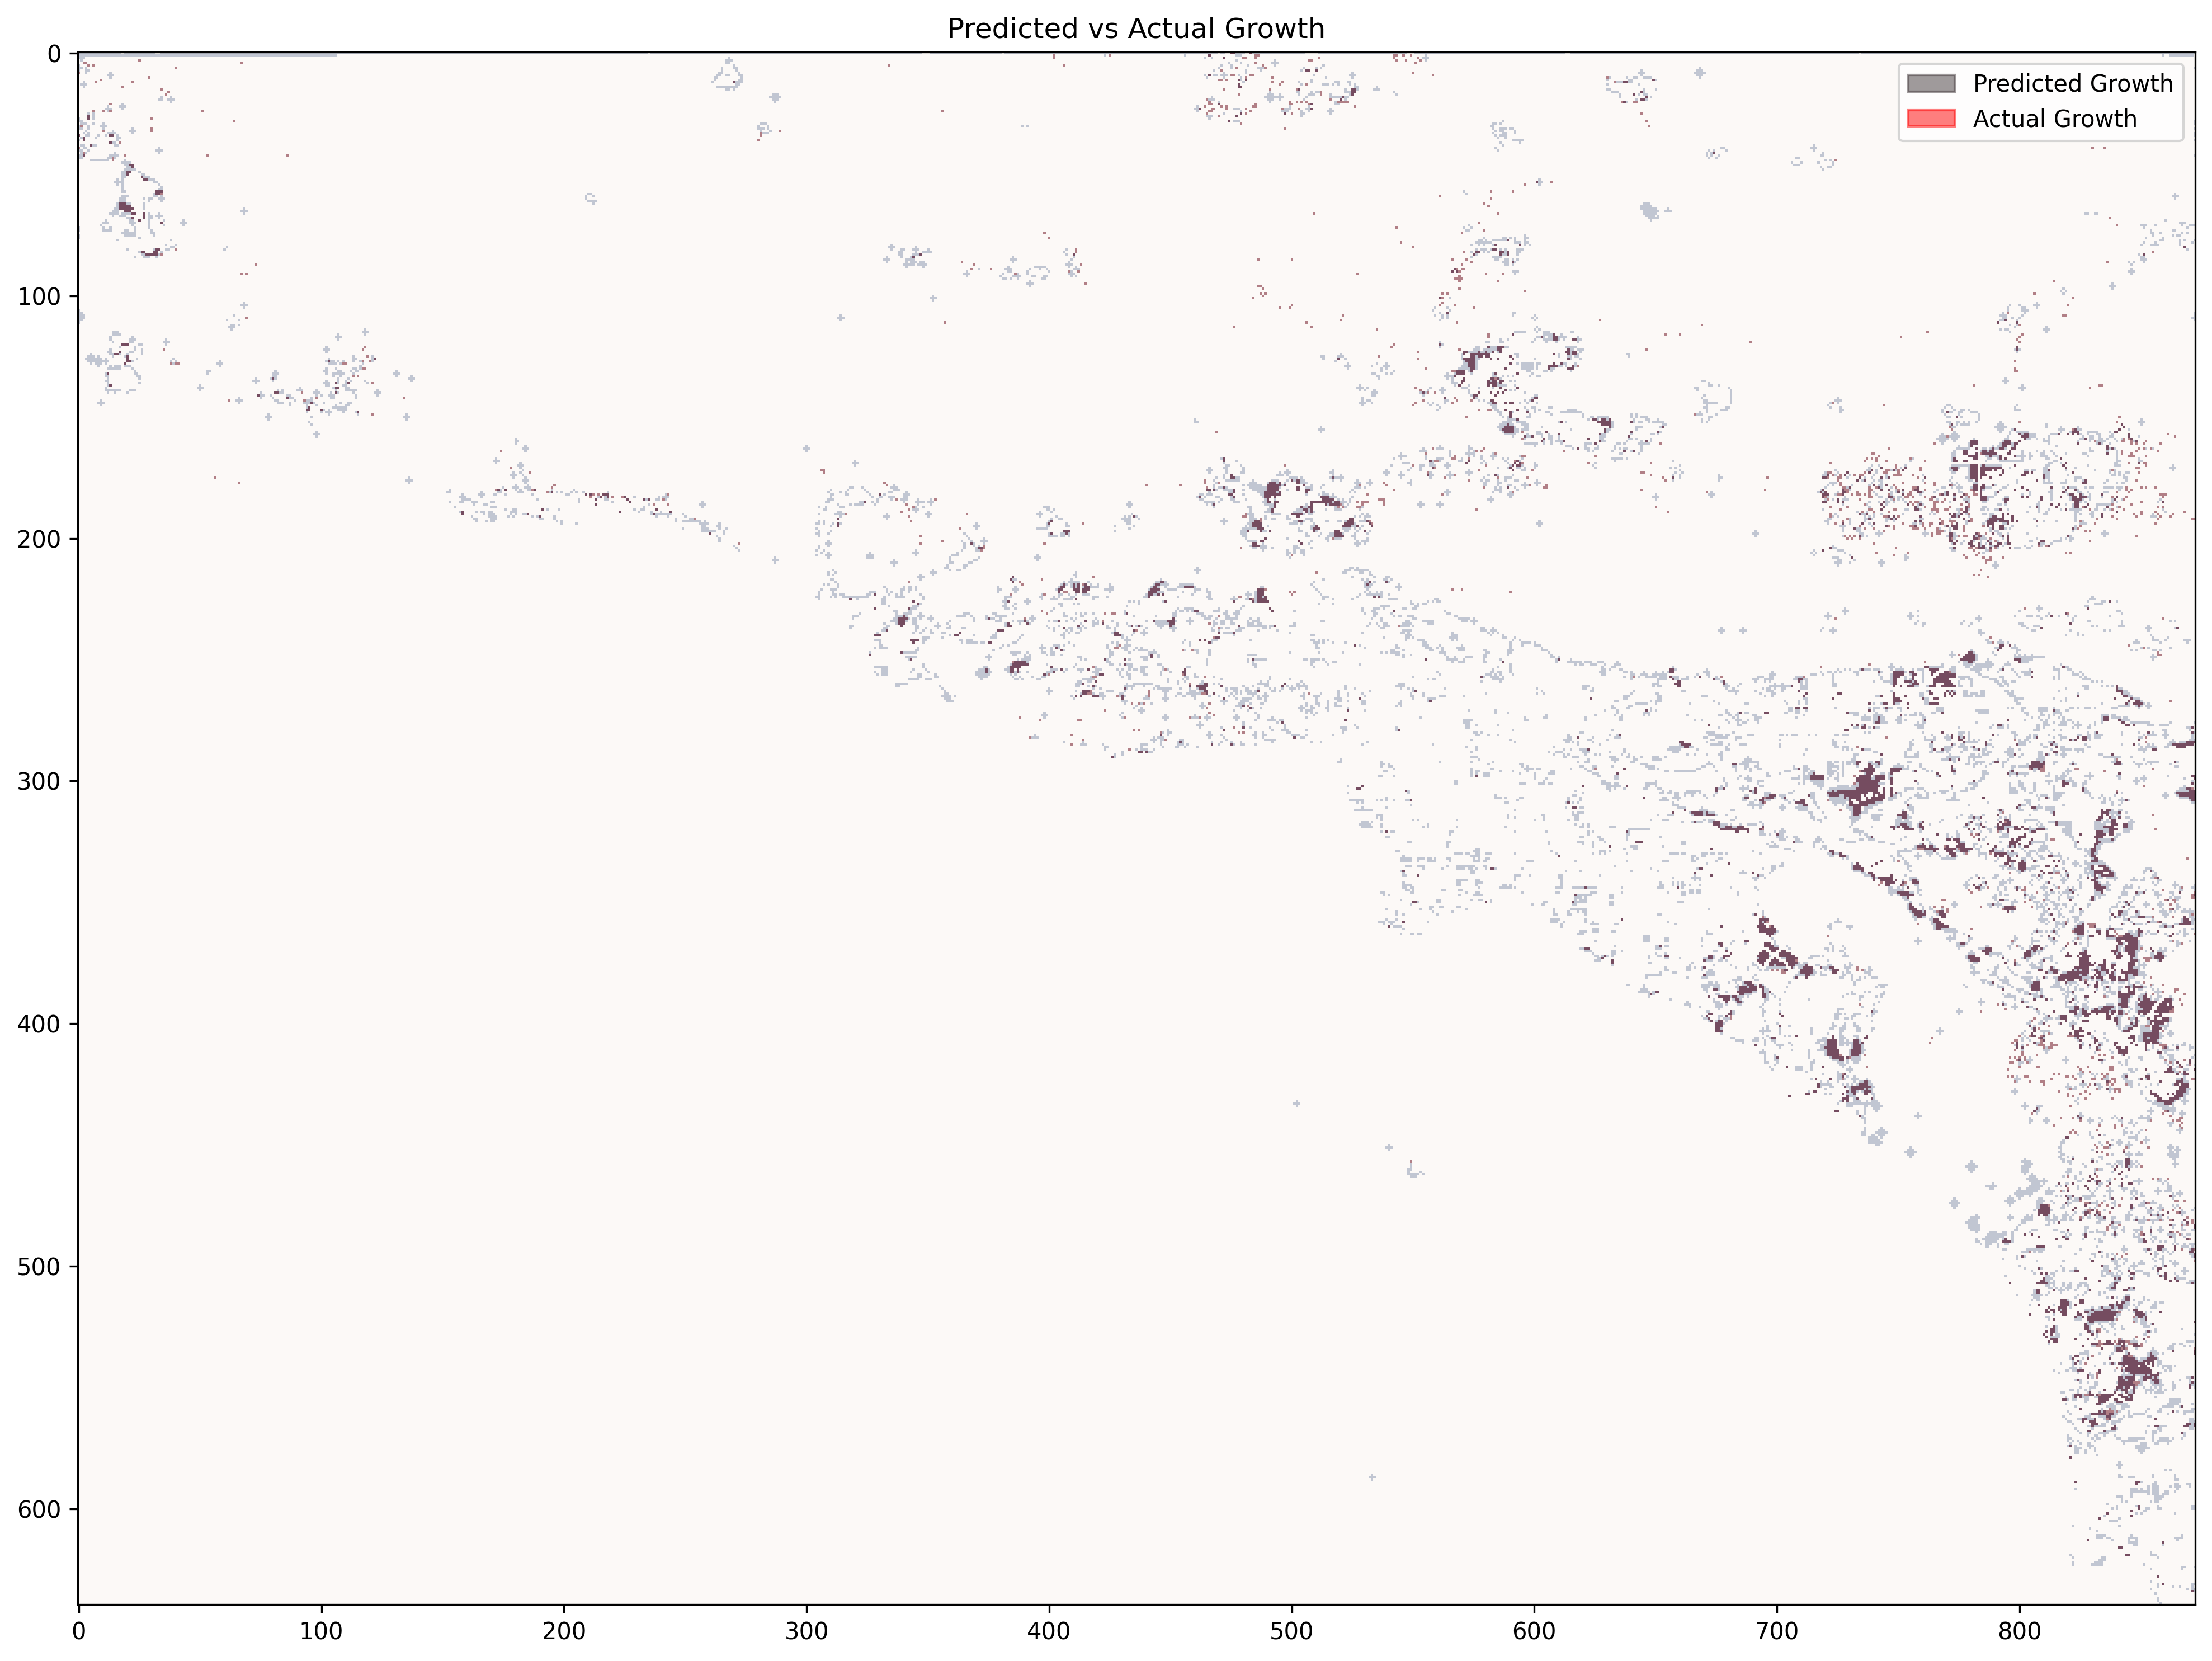

In [26]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
import matplotlib.pyplot as plt

# 加载CSV文件
predicted_csv = "/home/limingl/wildfire/CA_model/Output_730/Growth_Matrix.csv"
#predicted_csv = "D:/wildfire/Output_10/growth_count_map_0.5_1_0.5_1_1_1.csv"  # 替换成你的预测增长次数CSV文件路径
actual_csv = "/home/limingl/wildfire/CA_model/Growth_2021.csv"


predicted_growth = pd.read_csv(predicted_csv, header=None).to_numpy()
actual_growth = pd.read_csv(actual_csv, header=None).to_numpy()

# 将矩阵转换为一维数组
predicted_growth_flat = predicted_growth.flatten()
actual_growth_flat = actual_growth.flatten()

# 设置阈值
threshold = 1

# 计算 ROC AUC
auc = roc_auc_score(actual_growth_flat, predicted_growth_flat)
print(f"AUC: {auc:.4f}")

# 计算 Balanced Accuracy
# 将预测值二值化
predicted_growth_binary = (predicted_growth_flat >= threshold).astype(int)
balanced_acc = balanced_accuracy_score(actual_growth_flat, predicted_growth_binary)
print(f"Balanced Accuracy: {balanced_acc:.4f}")

# 计算 Mean %Dev Correct
mean_dev_correct = np.mean(np.abs(predicted_growth_flat - actual_growth_flat))
print(f"Mean %Dev Correct: {mean_dev_correct:.4f}")

# 计算真实增长的cell占预测增长的cell的百分比
predicted_growth_cells = (predicted_growth_flat >= threshold).astype(int)

true_positives = np.sum((actual_growth_flat == 1) & (predicted_growth_cells == 1))
predicted_positives = np.sum(predicted_growth_cells)

if predicted_positives == 0:
    percentage = 0
else:
    percentage = (true_positives / predicted_positives) * 100

print(f"ID: {percentage:.2f}%")

# 可视化预测增长和实际增长
fig, ax = plt.subplots(figsize=(15, 10), dpi=300)  # 增加DPI提高分辨率

# 使用不同的颜色或透明度叠加显示
predicted_growth_visual = (predicted_growth >= threshold).astype(int)
ax.imshow(predicted_growth_visual, cmap='Blues', alpha=0.5, label='Predicted Growth')

actual_growth_visual = (actual_growth == 1).astype(int)
ax.imshow(actual_growth_visual, cmap='Reds', alpha=0.5, label='Actual Growth')

# 添加图例
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#42383A', edgecolor='#42383A', alpha=0.5, label='Predicted Growth'),
                   Patch(facecolor='red', edgecolor='red', alpha=0.5, label='Actual Growth')]
ax.legend(handles=legend_elements, loc='upper right')

# 添加标题
ax.set_title('Predicted vs Actual Growth')

# 保存图像并设置高分辨率
plt.tight_layout()
plt.savefig('high_resolution_plot.png', dpi=300)  # 保存为高分辨率图像
#plt.close(fig)  # 关闭图像以释放内存

# 如果想要同时显示图像的话，可以移除下行的 plt.close 并添加 plt.show
plt.show()

In [3]:
import numpy as np
import pandas as pd
import glob

def load_data(initial_map_file, prediction_files_path):
    # Load initial map
    initial_map = pd.read_csv(initial_map_file).values

    # Load all prediction data
    all_files = glob.glob(prediction_files_path)
    prediction_maps = [pd.read_csv(f).values for f in all_files]
    
    return initial_map, prediction_maps

def calculate_growth_regions(initial_map, prediction_maps):
    # Calculate growth regions
    growth_maps = [(initial_map == 0) & ((pred_map == 1) | (pred_map == 2)) for pred_map in prediction_maps]
    return growth_maps

def calculate_invariant_regions(growth_maps, theta):
    # Stack all growth maps to calculate the invariant region
    stacked = np.stack(growth_maps, axis=2)
    # Calculate the threshold
    threshold = theta / 100 * len(growth_maps)

    # Calculate invariant developed and non-developed regions
    developed_counts = np.sum(stacked, axis=2)
    invariant_developed = (developed_counts >= threshold)
    invariant_non_developed = (developed_counts < threshold)

    return invariant_developed, invariant_non_developed

def calculate_accuracy(region, historical_map, correct_value):
    # Calculate accuracy for a given invariant region and historical data
    if correct_value == 1:
        # For developed regions (1 in historical map means change from 0 to 1 or 0 to 2)
        region_matches = (region & (historical_map == 1))
    else:
        # For non-developed regions (0 in historical map means no change)
        region_matches = (region & (historical_map == 0))
    
    return np.sum(region_matches) / np.sum(region) if np.sum(region) > 0 else 0

def main(initial_map_file, prediction_files_path, historical_map_file, theta):
    # Load initial, prediction and historical maps
    initial_map, prediction_maps = load_data(initial_map_file, prediction_files_path)
    historical_map = pd.read_csv(historical_map_file).values
    
    # Calculate growth regions
    growth_maps = calculate_growth_regions(initial_map, prediction_maps)
    
    # Calculate invariant regions
    invariant_developed, invariant_non_developed = calculate_invariant_regions(growth_maps, theta)

    # Calculate accuracies
    ID = calculate_accuracy(invariant_developed, historical_map, 1)
    IU = calculate_accuracy(invariant_non_developed, historical_map, 0)

    print(f"ID: {ID * 100:.2f}%")
    print(f"IU: {IU * 100:.2f}%")

# Use the function in Jupyter Notebook
initial_map_file = "D:/wildfire/Initial_map.csv"
prediction_files_path = "D:/wildfire/Output_10/growth_count_map_0.5_1_0.5_1_1_1.csv"
historical_map_file = "D:/wildfire/Growth_2021.csv"
theta = 6

main(initial_map_file, prediction_files_path, historical_map_file, theta)

FileNotFoundError: [Errno 2] No such file or directory: 'D:/wildfire/Initial_map.csv'

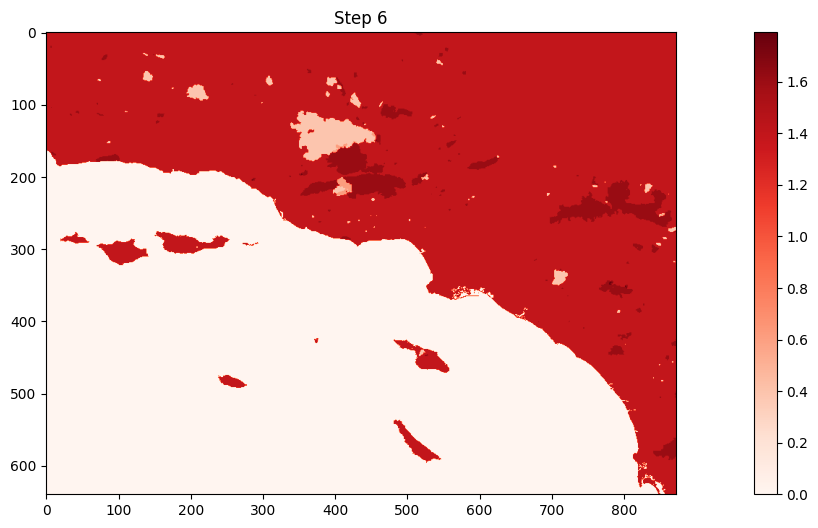

In [7]:
from Tolerance import Tolerance_maps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
burned_map_folder = "/home/limingl/wildfire/Code/Output_10/Fire_map/"
bill_file = "/home/limingl/wildfire/Code/Output_10/Forest_Education.xlsx"
relief_map_folder = "/home/limingl/wildfire/Code/Output_10/Relief_map/"
#Historical_map_folder = "/home/limingl/wildfire/Code/Output_10/Historical_Land_Use/"
A, B, C, D, step = 1, 1, 1, 1, 6

map = Tolerance_maps(burned_map_folder, bill_file, relief_map_folder, A, B, C, D, step)



#percentiles = np.percentile(map, [25, 50, 75])
#print(f"25th Percentile: {percentiles[0]}")
#print(f"50th Percentile: {percentiles[1]}")
#print(f"75th Percentile: {percentiles[2]}")
#min_value = np.min(map)
#max_value = np.max(map)
#mean_value = np.mean(map)
#median_value = np.median(map)
#std_deviation = np.std(map)
#
#print(f"Min: {min_value}")
#print(f"Max: {max_value}")
#print(f"Mean: {mean_value}")
#print(f"Median: {median_value}")
#print(f"Standard Deviation: {std_deviation}")
#initial_population_map = pd.read_csv("/home/limingl/wildfire/CA_model/Population_2000.csv", header=None).values
#map[initial_population_map == 0] = 0
if map is not None:
    plt.figure(figsize=(20, 6))
    plt.imshow(map, cmap='Reds')
    plt.title(f'Step {step}')
    plt.colorbar()
    plt.show()
    plt.close()

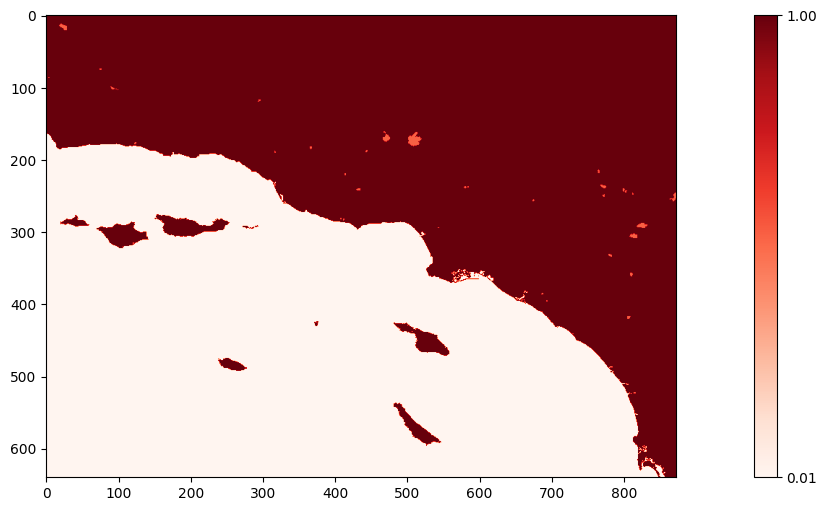

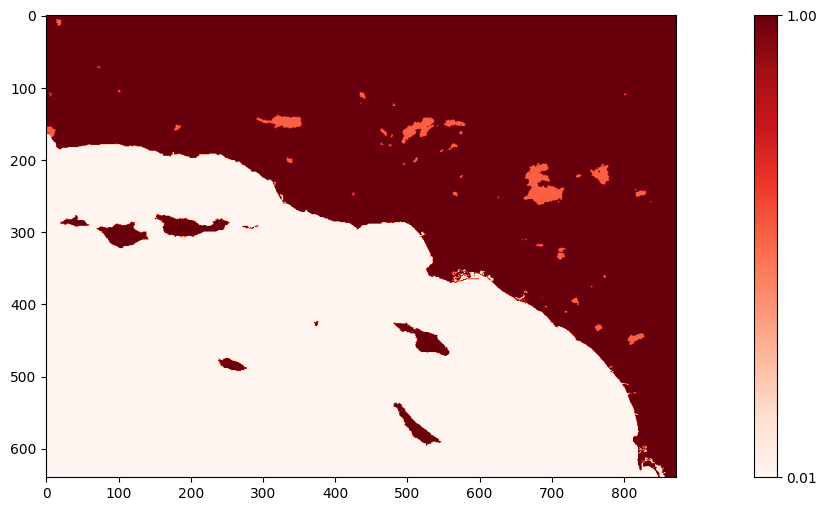

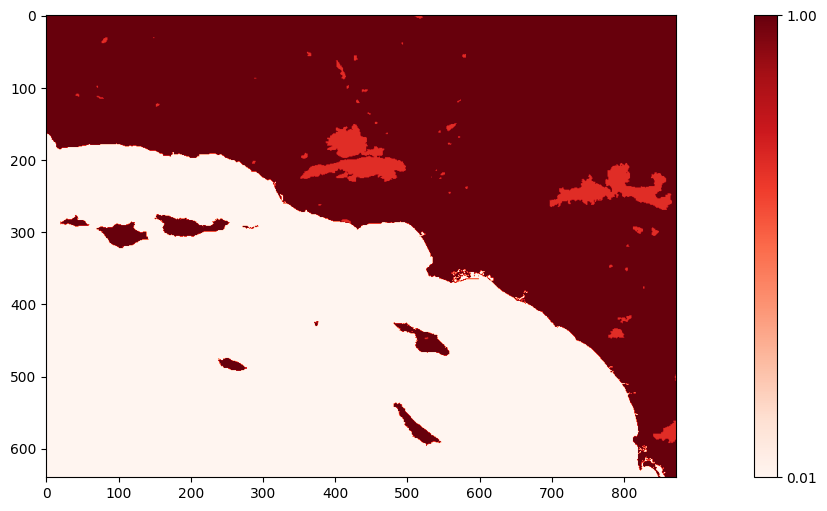

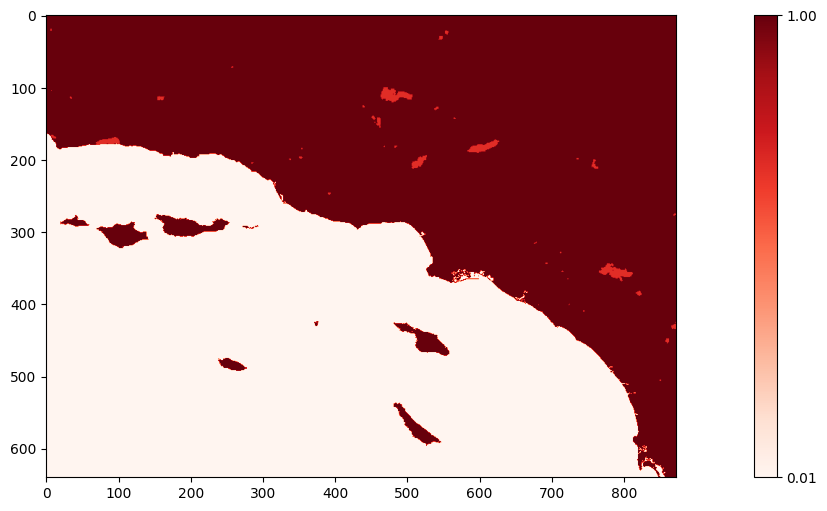

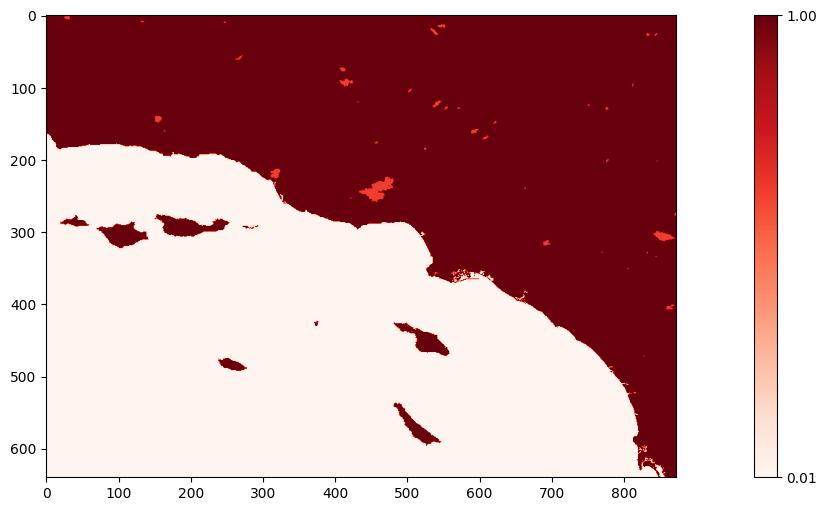

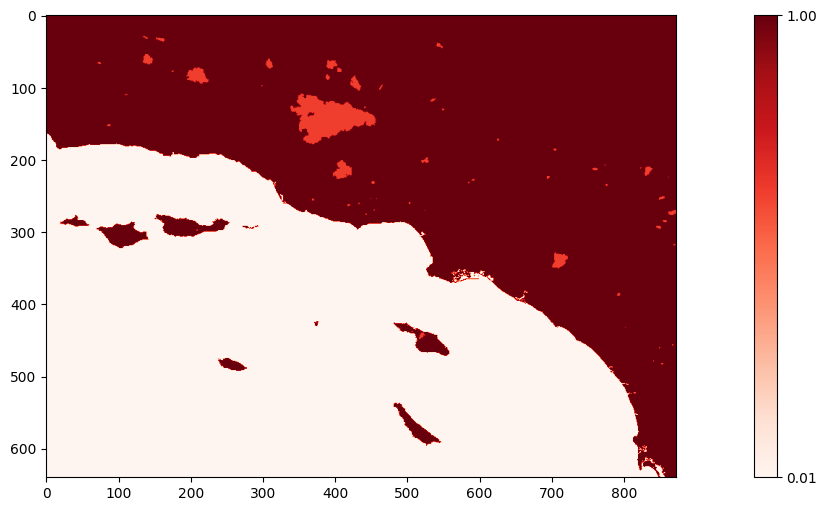

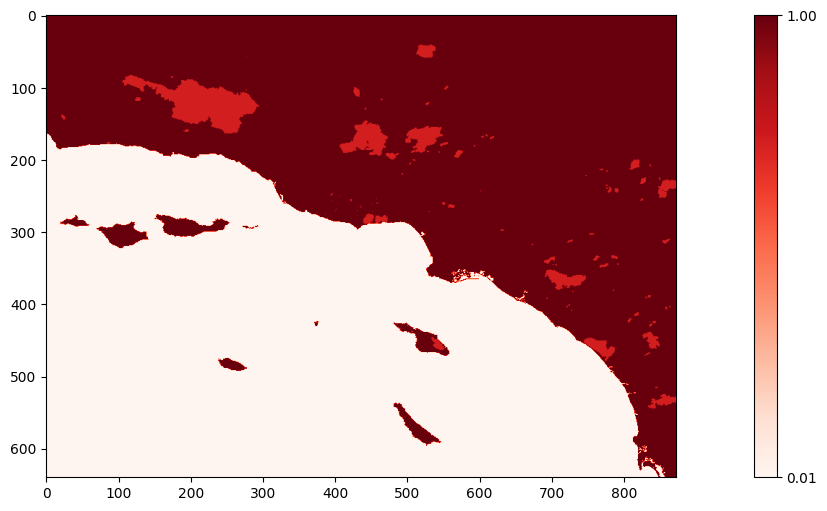

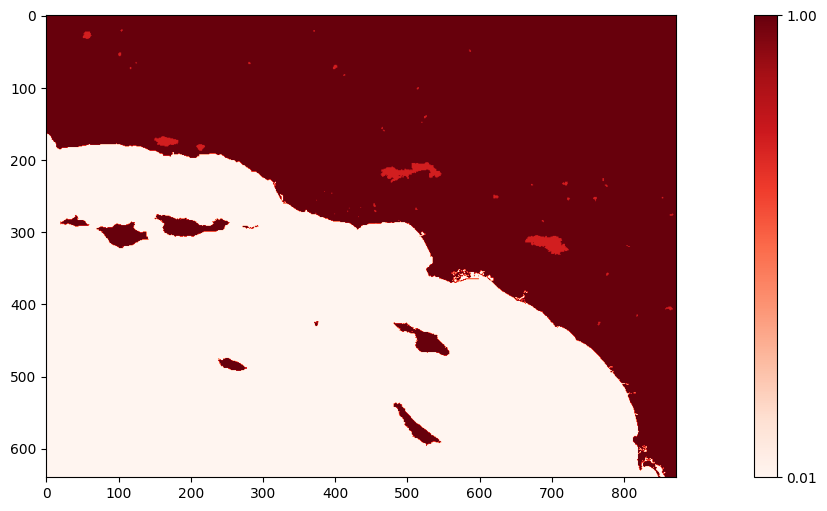

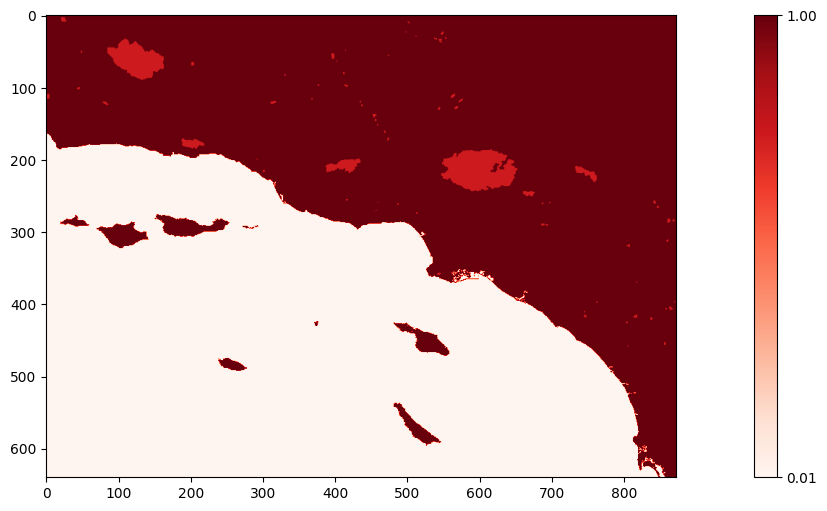

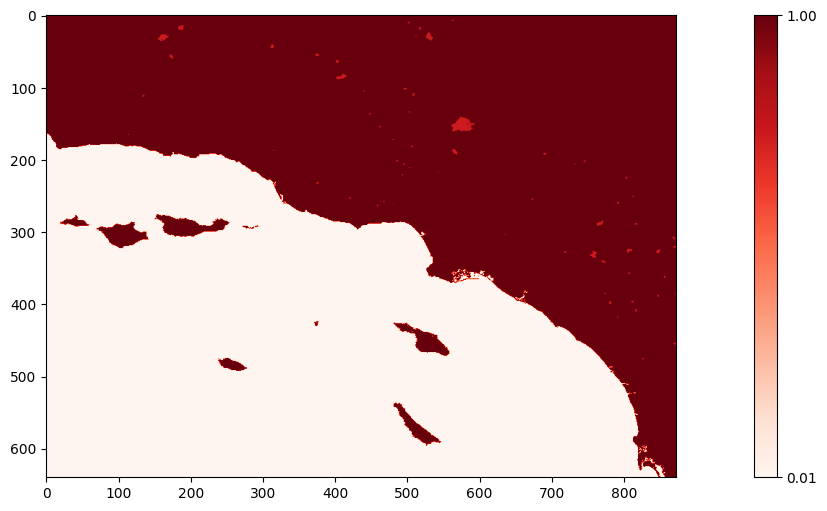

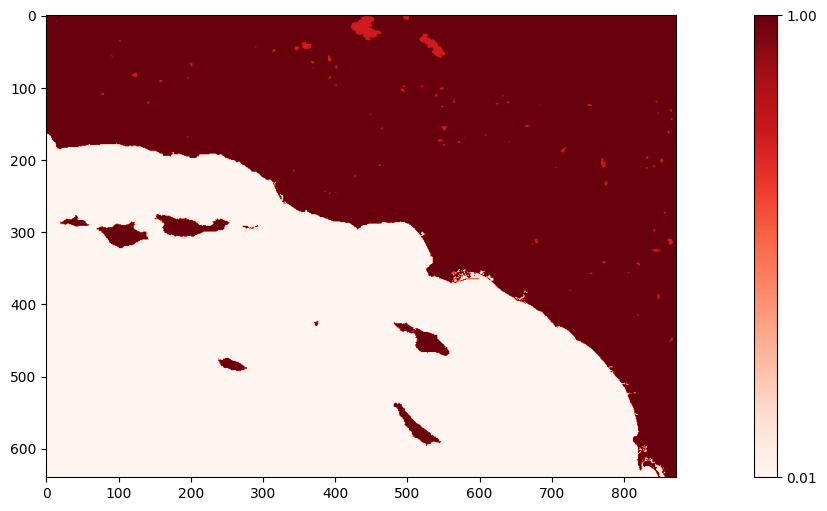

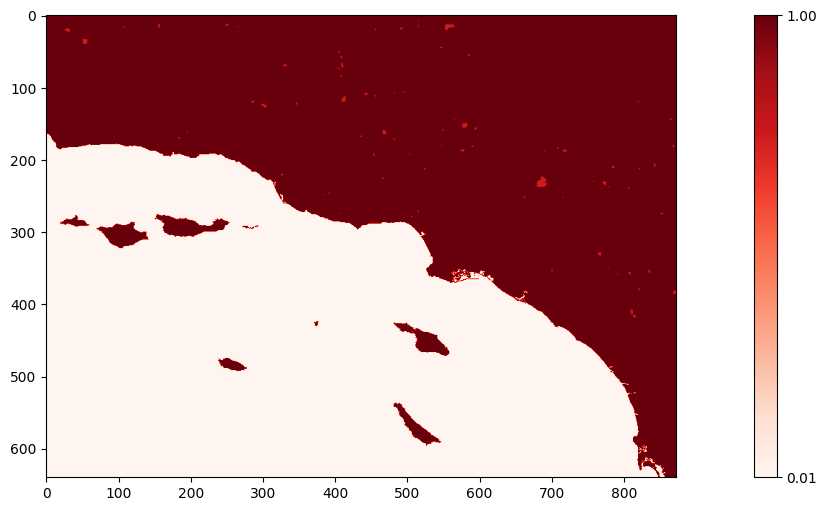

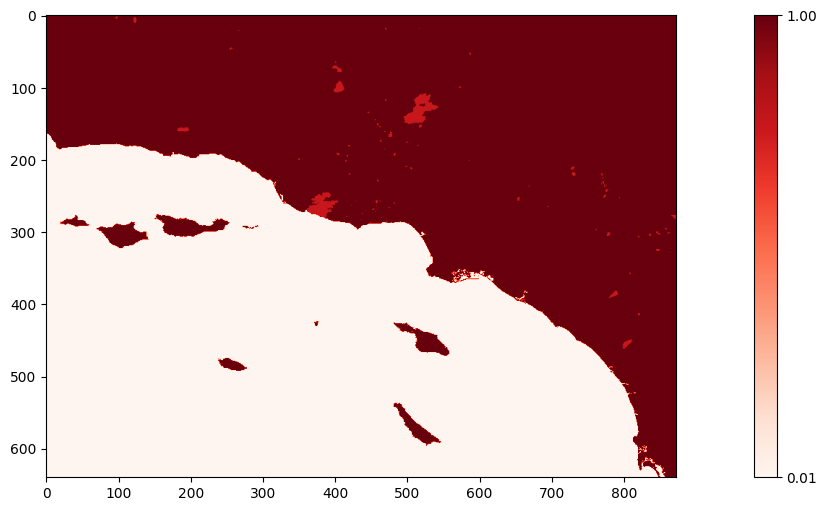

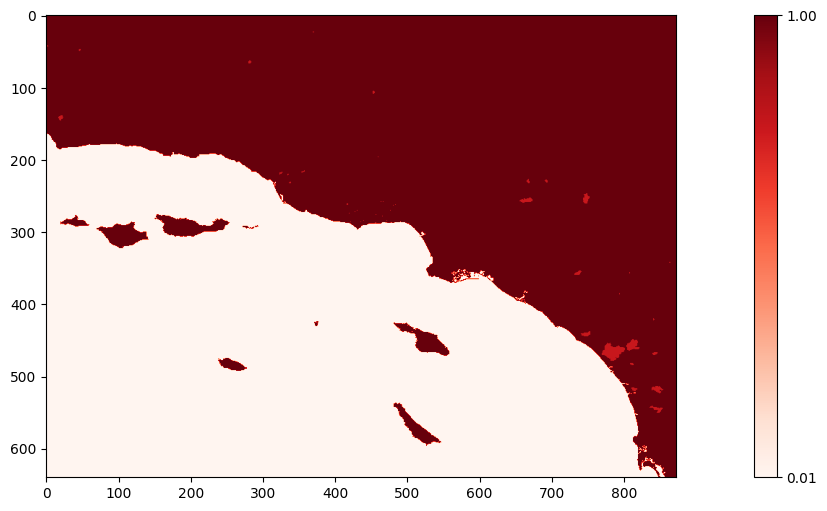

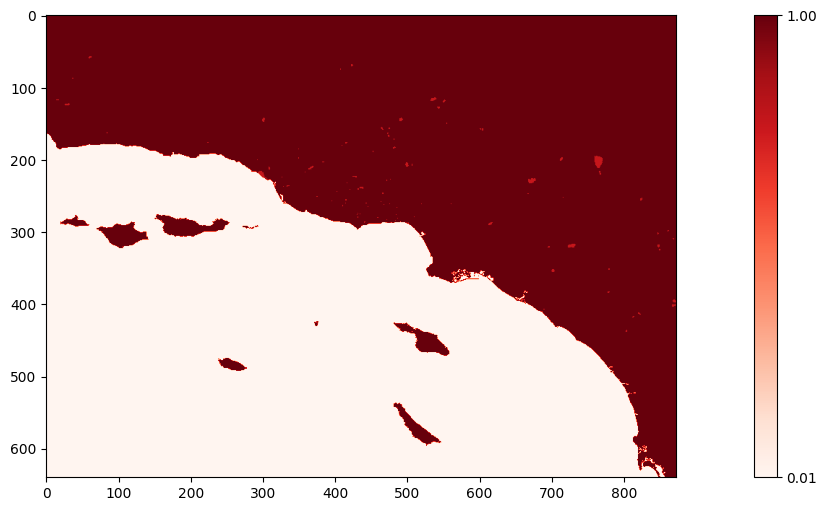

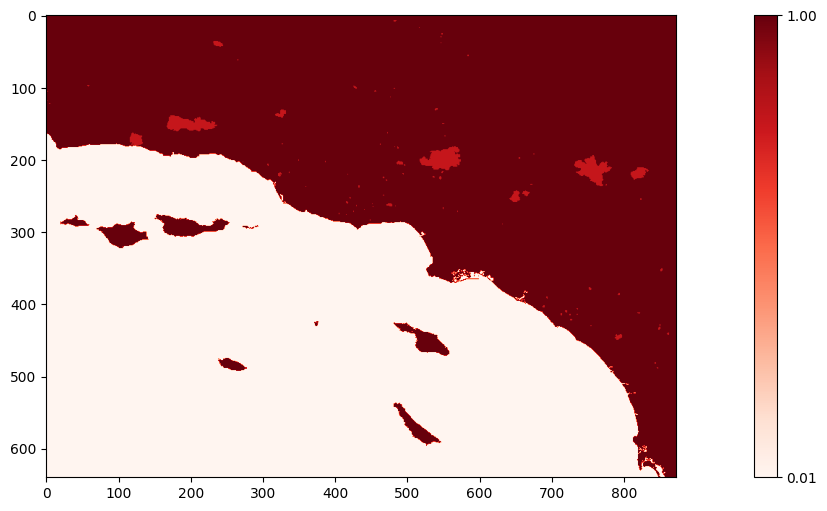

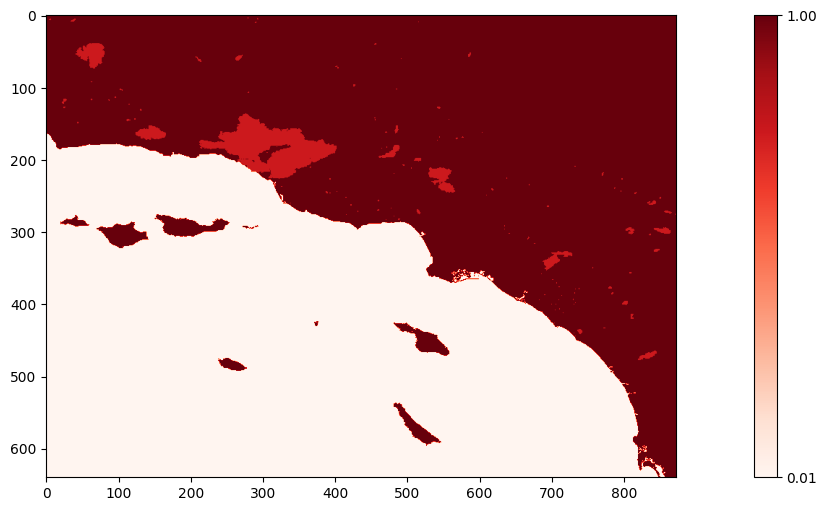

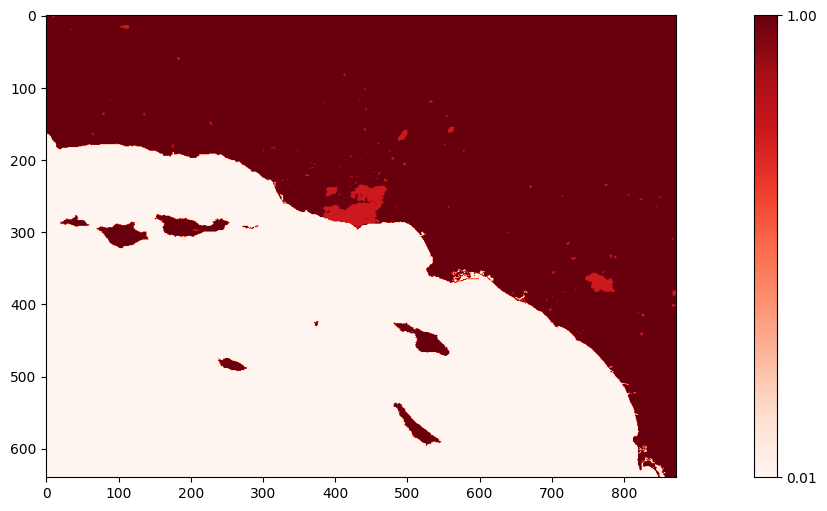

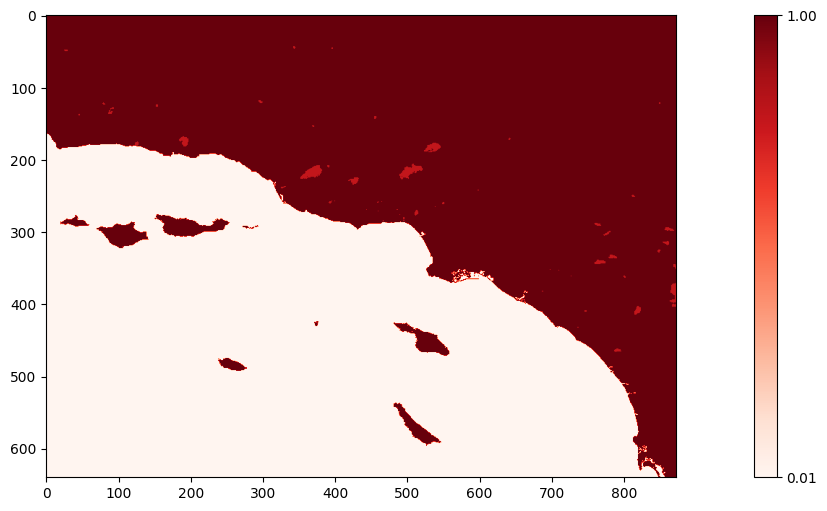

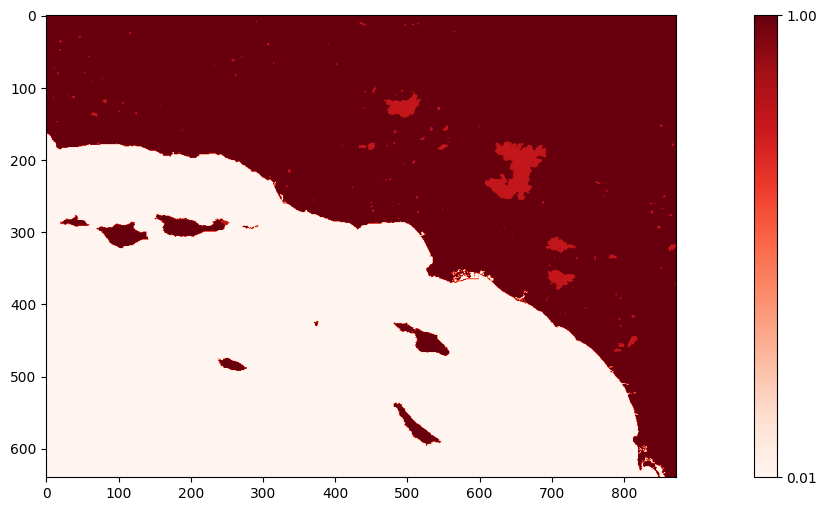

In [2]:
from Tolerance import Tolerance_maps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#burned_map_folder = "/home/limingl/wildfire/Code/Output_10/Fire_map/"
#bill_file = "/home/limingl/wildfire/Code/Output_10/Forest_Education.xlsx"
#relief_map_folder = "/home/limingl/wildfire/Code/Output_10/Relief_map/"
## Historical_map_folder = "/home/limingl/wildfire/Code/Output_10/Historical_Land_Use/"
##A, B, C, D =7.936, 5.8, 1.623, 7.008   
#relief_cum_map = np.ones((640, 873))
#A, B, C, D =1,1,1,1 
## Loop through each step from 1 to 20
#for step in range(1, 21):
#    # Generate the map for the current step
#    map = Tolerance_maps(burned_map_folder, bill_file, relief_map_folder, A, B, C, D, step)
#    
#    # Check if the map is not empty
#    if map is not None:
#        plt.figure(figsize=(20, 6))
#        img = plt.imshow(map, cmap='Reds')
#        #img = plt.imshow(map, cmap='viridis')
#        #plt.title(f'Step {step}')
#        
#        # Create a colorbar with custom ticks and labels
#        cbar = plt.colorbar(img, ticks=[map.min(), map.max()])
#        #cbar.set_ticklabels(['High', 'Low'])
#        
#        plt.show()
#        plt.close()

burned_map_folder = "/home/limingl/wildfire/Code/Output_10/Fire_map/"
bill_file = "/home/limingl/wildfire/Code/Output_10/Forest_Education.xlsx"
relief_map_folder = "/home/limingl/wildfire/Code/Output_10/Relief_map/"

A, B, C, D =1, 1, 1, 1
#A, B, C, D =7.936, 5.8, 1.623, 7.008 
# Loop through each step from 1 to 20
for step in range(1, 21):
    # Generate the map for the current step
    map = Tolerance_maps(burned_map_folder, bill_file, relief_map_folder, A, B, C, D, step)
    
    # Check if the map is not empty
    if map is not None:
        plt.figure(figsize=(20, 6))
        img = plt.imshow(map, cmap='Reds')
        #img = plt.imshow(map, cmap='viridis')
        
        # Create a colorbar with custom ticks and labels
        cbar = plt.colorbar(img, ticks=[map.min(), map.max()])
        
        plt.show()
        plt.close()

Forest bill for step 8: 9
Education bill for step 8: 0
Resulting Matrix:
[[9. 9. 9. ... 9. 9. 9.]
 [9. 9. 9. ... 9. 9. 9.]
 [9. 9. 9. ... 9. 9. 9.]
 ...
 [0. 0. 0. ... 9. 9. 9.]
 [0. 0. 0. ... 9. 9. 9.]
 [0. 0. 0. ... 9. 9. 9.]]
25th Percentile: 0.012286987165447016
50th Percentile: 8.02339727608037
75th Percentile: 9.023368649193076
Min: -0.9999864772956291
Max: 13.99994857829983
Mean: 4.572489427191024
Median: 8.02339727608037
Standard Deviation: 4.563332531095602


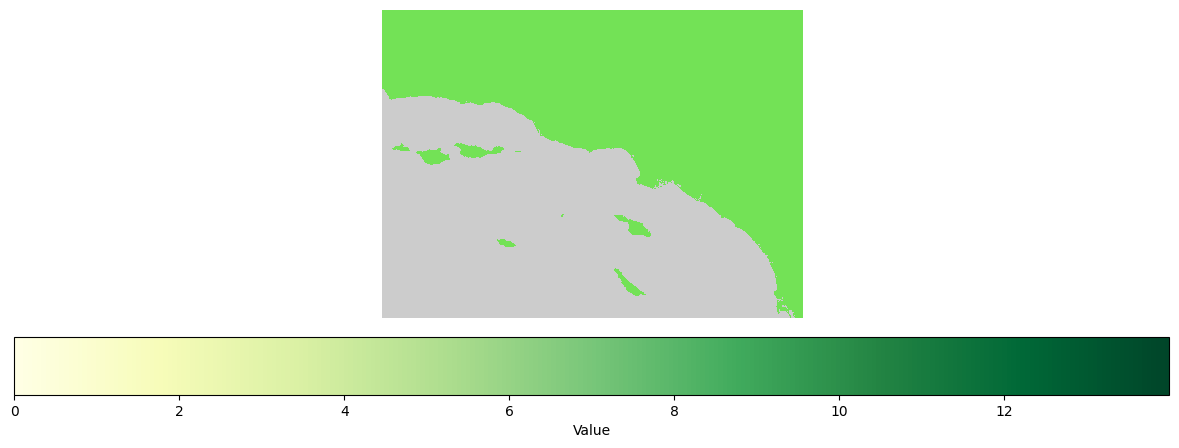

In [4]:
from Tolerance import Tolerance_maps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# 定义路径
burned_map_folder = '/home/limingl/wildfire/CA_model/Output_10/Fire_map'
bill_file = '/home/limingl/wildfire/CA_model/Output_10/Forest_Education.xlsx'
relief_map_folder = '/home/limingl/wildfire/CA_model/Output_10/Relief_map'

risk_map_path = '/home/limingl/wildfire/CA_model/Output_10/Fire_count.csv'
A, B, C, D, step = 5, 1, 1, 1, 8

# 创建Tolerance_maps实例
map = Tolerance_maps(burned_map_folder, bill_file, relief_map_folder, A, B, C, D, step)

# 添加随机噪声
random_noise = np.random.uniform(low=-1, high=1, size=map.shape)
map = map + random_noise

# 计算统计量
percentiles = np.percentile(map, [25, 50, 75])
print(f"25th Percentile: {percentiles[0]}")
print(f"50th Percentile: {percentiles[1]}")
print(f"75th Percentile: {percentiles[2]}")
min_value = np.min(map)
max_value = np.max(map)
mean_value = np.mean(map)
median_value = np.median(map)
std_deviation = np.std(map)
print(f"Min: {min_value}")
print(f"Max: {max_value}")
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Standard Deviation: {std_deviation}")

# 读取初始人口分布
initial_population_map = pd.read_csv("/home/limingl/wildfire/CA_model/Population_2000.csv", header=None).values
map[initial_population_map == 0] = 0

# 创建自定义颜色映射
colors = ['#CCCCCC', '#73E256']
# colors = ['#382055', '#4FB233']
custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", colors)

# 读取risk_map
risk_map = pd.read_csv(risk_map_path, header=None).values

# 计算 map 的平均值
average_value = np.mean(map)

# 创建仅表示颜色的数组
color_map = np.full(map.shape, '#CCCCCC', dtype='<U7')  # 默认颜色

# 设置根据 map 值的颜色
color_map[map > average_value] = '#73E256'

# 将高风险区域且小于平均值的位置设为红色
color_map[(risk_map > 0) & (map < average_value)] = '#FF0000'

# 创建一个掩膜来掩盖红色区域
mask = (risk_map > 0) & (map < average_value)

# 对于非红色区域按数值大小渐进绘制
non_red_map = np.ma.masked_array(map, mask=mask)
norm = plt.Normalize(vmin=np.min(non_red_map), vmax=np.max(non_red_map))

# 绘制图像
fig, ax = plt.subplots(figsize=(30, 5))
custom_cmap = plt.get_cmap('YlGn')  # 选择一个渐进色表

# 将非红色区域绘制为颜色渐变
c = ax.imshow(non_red_map, cmap=custom_cmap, norm=norm)

# 然后绘制红色区域
color_map_rgb = np.zeros((*color_map.shape, 3), dtype=float)
for key, hex_value in zip(['#CCCCCC', '#73E256', '#FF0000'], [(204/255, 204/255, 204/255), 
                                                               (115/255, 226/255, 86/255), 
                                                               (1, 0, 0)]):
    color_map_rgb[color_map == key] = hex_value

# 绘制所有区域
ax.imshow(color_map_rgb, interpolation='none')
ax.axis('off')

# 添加颜色条
cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
cbar.ax.set_xlabel('Value')

plt.show()

In [3]:

import pandas as pd

# 读取初始和最终地图
initial_map = pd.read_csv("/home/limingl/wildfire/CA_model/Initial_final.csv", header=None).values
final_map = pd.read_csv("/home/limingl/wildfire/CA_model/Output_10/Historical_Land_Use/Historical_land_2020.csv", header=None).values

# 计算实际增长
Actual_growth = ((final_map == 1) | (final_map == 2)) & (initial_map == 0)

# 将布尔值矩阵转换为整数矩阵
Actual_growth_int = Actual_growth.astype(int)
print(np.sum(Actual_growth_int))
# 保存矩阵到文件
growth_output_file = "/home/limingl/wildfire/CA_model/Output_10/Acutal_Growth_Matrix.csv"
pd.DataFrame(Actual_growth_int).to_csv(growth_output_file, header=None, index=False)

5506


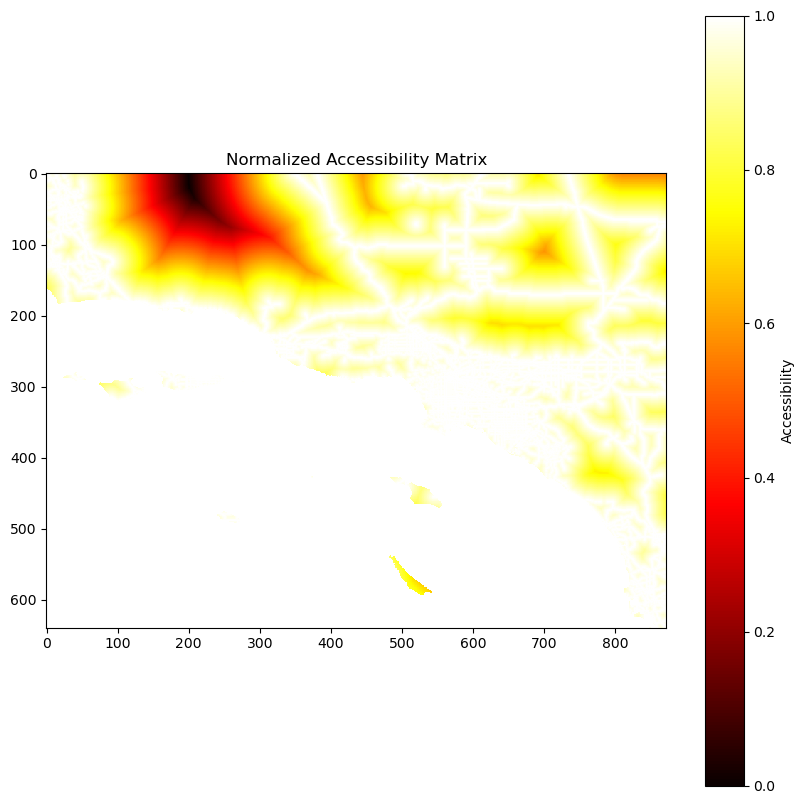

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt

def calculate_accessibility(matrix):
    # 找出矩阵中road（4）的位置
    road_mask = (matrix == 4)
    
    # 计算每个点到road（4）位置的距离
    dist_up = distance_transform_edt(~road_mask)
    dist_down = distance_transform_edt(~road_mask[::-1, :])[::-1, :]
    dist_left = distance_transform_edt(~road_mask[:, ::-1])[:, ::-1]
    dist_right = distance_transform_edt(~road_mask.T[:, ::-1].T)[:, ::-1]

    # 计算可达性，距离越小可达性越高
    dist = np.minimum(np.minimum(dist_up, dist_down), np.minimum(dist_left, dist_right))
    
    # 将原先的3, 4, 5的位置设为0
    accessibility = np.where(matrix == 3, 0, dist)
    accessibility = np.where(matrix == 4, 0, accessibility)
    accessibility = np.where(matrix == 5, 0, accessibility)

    return accessibility

def normalize_accessibility(accessibility):
    # 对可达性矩阵进行归一化处理，使结果在[0, 1]范围内
    min_val = np.min(accessibility)
    max_val = np.max(accessibility)
    if max_val > min_val:  # 避免除以零
        normalized_accessibility = (accessibility - min_val) / (max_val - min_val)
    else:
        normalized_accessibility = accessibility

    # 归一化处理后反向转换
    normalized_accessibility = 1 - normalized_accessibility
    
    return normalized_accessibility

# 读入CSV文件
matrix = pd.read_csv('/home/limingl/wildfire/CA_model/Initial_final.csv', header=None).values

# 计算可达性矩阵
accessibility_matrix = calculate_accessibility(matrix)
normalized_accessibility_matrix = normalize_accessibility(accessibility_matrix)

# Save the normalized accessibility matrix to a CSV file
output_csv_path = '/home/limingl/wildfire/CA_model/Highway_normalized_accessibility_matrix.csv'
pd.DataFrame(normalized_accessibility_matrix).to_csv(output_csv_path, header=False, index=False)

# 可视化
plt.figure(figsize=(10, 10))
plt.imshow(normalized_accessibility_matrix, cmap='hot', interpolation='nearest')
plt.colorbar(label='Accessibility')
plt.title('Normalized Accessibility Matrix')
plt.show()

In [11]:
import pandas as pd
import numpy as np

initial_population_map = pd.read_csv("/home/limingl/wildfire/CA_model/Population_2000.csv", header=None).values
initial_population_map[initial_population_map == 0.01] = 0
initial_map = pd.read_csv("/home/limingl/wildfire/CA_model/Initial_final.csv", header=None).values

differences = (initial_population_map == 0) &((initial_map == 1) | (initial_map ==2))
differences_1 = (initial_population_map != 0) &(initial_map == 0)
print(np.sum(differences))
print(np.sum(differences_1))

initial_population_map[(initial_population_map == 0) & ((initial_map == 1) | (initial_map ==2))] = 0.01
initial_map[(initial_population_map != 0) &(initial_map == 0)] = 1

differences_2 = (initial_population_map == 0) &((initial_map == 1) | (initial_map ==2))
differences_3 = (initial_population_map != 0) &(initial_map == 0)
print(np.sum(differences_2))
print(np.sum(differences_3))


10680
4775
0
0
